In [1]:
# %env FAIRSEQ=`realpath ../fairseq`
# %env USERDIR=`realpath ../simultaneous_translation`
# %env PYTHONPATH=%env USERDIR"$FAIRSEQ:$PYTHONPATH"
# %env 
# %env DATABIN=../DATA/toy_data/data-bin
# %env SRC=chr
# %env TGT=num
import sys
sys.path.insert(0, "../fairseq")
# sys.path.insert(0, "../")
# %load_ext autoreload
# %autoreload 2

In [2]:
# https://github.com/pytorch/fairseq/blob/master/fairseq_cli/generate.py

In [20]:
from fairseq import (
    checkpoint_utils,
    options,
    quantization_utils,
    tasks,
    utils,
)
from torchinfo import summary
import logging
import os
import matplotlib.pyplot as plt

In [4]:
checkpoint="../exp/checkpoints/toy_dist2/checkpoint_best.pt"
inference_config_yaml="../exp/infer_toy.yaml"

states = checkpoint_utils.load_checkpoint_to_cpu(
    path=checkpoint, arg_overrides=None, load_on_all_ranks=False)
cfg = states["cfg"]
cfg.task.inference_config_yaml = inference_config_yaml

In [5]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=os.environ.get("LOGLEVEL", "INFO").upper(),
    stream=sys.stdout,
)
logger = logging.getLogger("fairseq_cli.train")

In [6]:
utils.import_user_module(cfg.common)

# Setup task, e.g., translation, language modeling, etc.
task = tasks.setup_task(cfg.task)
# Build model and criterion
model = task.build_model(cfg.model)
criterion = task.build_criterion(cfg.criterion)
logger.info(summary(model))
logger.info("task: {}".format(task.__class__.__name__))
logger.info("model: {}".format(model.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info(
    "num. shared model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters() if not getattr(p, "expert", False)),
        sum(p.numel() for p in model.parameters() if not getattr(p, "expert", False) and p.requires_grad)
    )
)


2021-05-30 01:07:10 | INFO | fairseq.tasks.translation | [chr] dictionary: 1312 types
2021-05-30 01:07:10 | INFO | fairseq.tasks.translation | [num] dictionary: 1312 types
2021-05-30 01:07:10 | INFO | fairseq_cli.train | ================================================================================
Layer (type:depth-idx)                                  Param #
ToySinkhornEncoderModel                                 --
├─S2TSinkhornCascadedEncoder: 1-1                       --
│    └─CausalTransformerEncoder: 2-1                    --
│    │    └─FairseqDropout: 3-1                         --
│    │    └─Embedding: 3-2                              335,872
│    │    └─SinusoidalPositionalEmbedding: 3-3          --
│    │    └─ModuleList: 3-4                             2,369,280
│    │    └─FusedLayerNorm: 3-5                         512
│    └─ModuleList: 2-2                                  --
│    │    └─NonCausalTransformerEncoderLayer: 3-6       789,760
│    │    └─NonCausalTrans

In [7]:
logger.info("loading model(s) from {}".format(cfg.common_eval.path))
model = task.build_model(cfg.model)
model.load_state_dict(
    states["model"], strict=True, model_cfg=cfg.model
)

# Optimize ensemble for generation
model.half()
model.cuda()
model.prepare_for_inference_(cfg)

2021-05-30 01:07:10 | INFO | fairseq_cli.train | loading model(s) from None


In [8]:
task.load_dataset(cfg.dataset.gen_subset, task_cfg=cfg.task)

2021-05-30 01:07:13 | INFO | fairseq.data.data_utils | loaded 3,000 examples from: ../DATA/toy_data/data-bin/test.chr-num.chr
2021-05-30 01:07:13 | INFO | fairseq.data.data_utils | loaded 3,000 examples from: ../DATA/toy_data/data-bin/test.chr-num.num
2021-05-30 01:07:13 | INFO | fairseq.tasks.translation | ../DATA/toy_data/data-bin test chr-num 3000 examples


In [9]:
# Load dataset 
itr = task.get_batch_iterator(
    dataset=task.dataset(cfg.dataset.gen_subset),
    max_tokens=cfg.dataset.max_tokens,
    max_sentences=cfg.dataset.batch_size,
    max_positions=utils.resolve_max_positions(
        task.max_positions(), model.max_positions() #*[m.max_positions() for m in models]
    ),
    ignore_invalid_inputs=cfg.dataset.skip_invalid_size_inputs_valid_test,
    required_batch_size_multiple=cfg.dataset.required_batch_size_multiple,
    seed=cfg.common.seed,
    num_shards=cfg.distributed_training.distributed_world_size,
    shard_id=cfg.distributed_training.distributed_rank,
    num_workers=cfg.dataset.num_workers,
    data_buffer_size=cfg.dataset.data_buffer_size,
).next_epoch_itr(shuffle=False)

generator = task.build_generator(
    [model], cfg.generation, extra_gen_cls_kwargs=None
)

# # Handle tokenization and BPE
# tokenizer = task.build_tokenizer(cfg.tokenizer)
# bpe = task.build_bpe(cfg.bpe)

# def decode_fn(x):
#     if bpe is not None:
#         x = bpe.decode(x)
#     if tokenizer is not None:
#         x = tokenizer.decode(x)
#     return x

# scorer = scoring.build_scorer(cfg.scoring, tgt_dict)

In [25]:
for sample in itr:
    sample = utils.move_to_cuda(sample)
    if "net_input" not in sample:
        continue

    break

logits, extra = model.forward(**sample["net_input"])

In [30]:
attn = extra["attn"][0].data.float().cpu().numpy()
attn.shape, attn.dtype

((128, 61, 61), dtype('float32'))

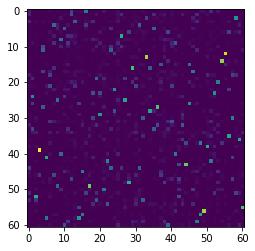

In [31]:
plt.imshow(attn[0])

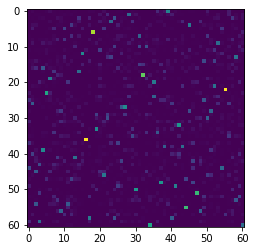

In [32]:
plt.imshow(attn[1])